In [27]:
# ensure we're using pytorch
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

In [28]:
# import libraries
import pandas as pd
import re
import torch
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import hstack
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertForSequenceClassification
from torch.optim import AdamW
from transformers import Trainer, TrainingArguments
from datasets import load_metric
from torch.nn import CrossEntropyLoss
from torch import tensor

# Problem Statement and Approach

In light of many GenAI technologies, there are an increasing number of fake job postings getting posted to our job board website which is causing job seekers loose trust in our website and job postings. Identifying fake job postings will be critical for building user trust as well as customer trust.

Job postings are text heavy and Natural Language Processing (NLP) provides an effective method for assessing job posting content. We'll aim to utilize DistilBERT, a transformer-based model to classify job postings. By fine tuning the DistilBERT model on labeled job posting data, our team will aim to build a classification model to deploy to our job search website to detect fake job postings. 

# Data Understanding (EDA)

In [29]:
# Load dataset
df = pd.read_csv('fake_job_postings.csv')

In [30]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [31]:
df.columns.tolist()

['job_id',
 'title',
 'location',
 'department',
 'salary_range',
 'company_profile',
 'description',
 'requirements',
 'benefits',
 'telecommuting',
 'has_company_logo',
 'has_questions',
 'employment_type',
 'required_experience',
 'required_education',
 'industry',
 'function',
 'fraudulent']

In [32]:
# check class balance for fake vs real
class_counts = df['fraudulent'].value_counts()

print(class_counts)

fraudulent
0    17014
1      866
Name: count, dtype: int64


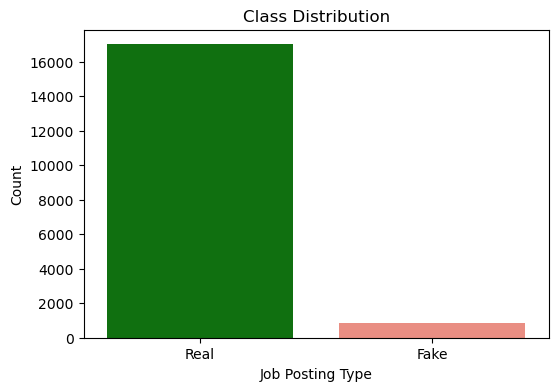

In [33]:
# set class field to string
df['fraudulent'] = df['fraudulent'].astype(str)

# plot class balance
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='fraudulent', hue='fraudulent', palette={'0': 'green', '1': 'salmon'}, legend=False)
plt.title('Class Distribution')
plt.xticks([0, 1], ['Real', 'Fake'])
plt.xlabel('Job Posting Type')
plt.ylabel('Count')
plt.show()

In [34]:
# check for missing data
missing_data = df.isnull().mean().sort_values(ascending=False)

missing_data

salary_range           0.839597
department             0.645805
required_education     0.453300
benefits               0.403356
required_experience    0.394295
function               0.361018
industry               0.274217
employment_type        0.194128
company_profile        0.185011
requirements           0.150783
location               0.019351
description            0.000056
job_id                 0.000000
telecommuting          0.000000
has_questions          0.000000
has_company_logo       0.000000
title                  0.000000
fraudulent             0.000000
dtype: float64

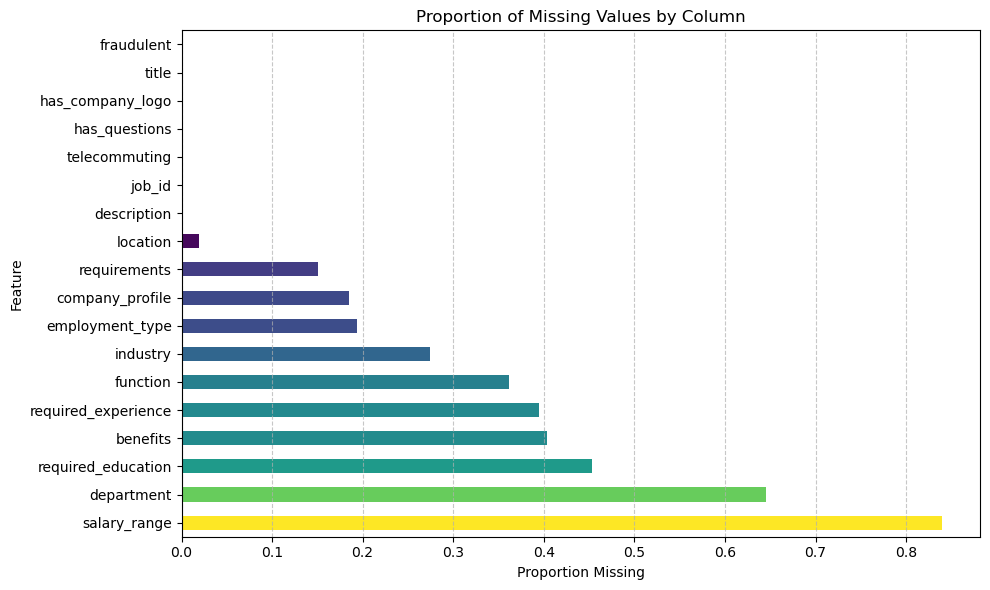

In [35]:
# adding colors to bars for ease of visualization
colors = plt.cm.viridis(missing_data.values / max(missing_data.values))

# plot missing values
plt.figure(figsize=(10, 6))
missing_data.plot(kind='barh', color=colors)
plt.title('Proportion of Missing Values by Column')
plt.xlabel('Proportion Missing')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

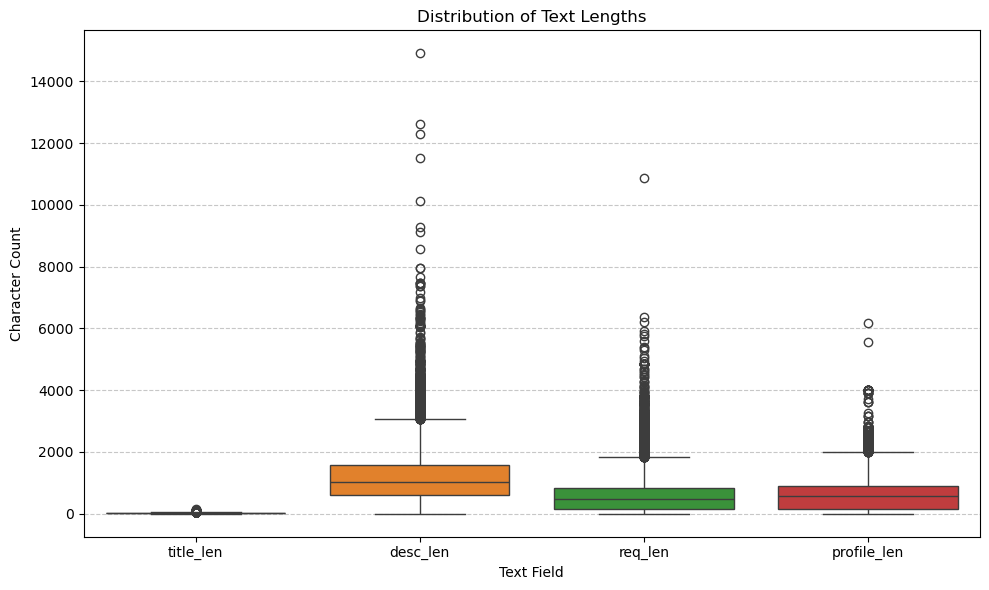

In [36]:
# check text length (these can be used as engineered features)
df['title_len'] = df['title'].apply(lambda x: len(str(x)))
df['desc_len'] = df['description'].apply(lambda x: len(str(x)))
df['req_len'] = df['requirements'].apply(lambda x: len(str(x)))
df['profile_len'] = df['company_profile'].apply(lambda x: len(str(x)))

# plot text length
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['title_len', 'desc_len', 'req_len', 'profile_len']])
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Field')
plt.ylabel('Character Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Data Preparation & Feature Engineering

In [37]:
# missing values
missing_summary = df.isnull().sum().sort_values(ascending=False)

# fill categorical columns with "unknown"
categorical_fill = ['department', 'salary_range', 'company_profile', 'requirements',
                    'benefits', 'employment_type', 'required_experience', 
                    'required_education', 'industry', 'function', 'location', 'description', 'title']

df[categorical_fill] = df[categorical_fill].fillna("Unknown")

# output results
remaining_missing = df.isnull().sum()
print("\n✅ Missing values after filling:")
print(remaining_missing[remaining_missing > 0] if remaining_missing.sum() > 0 else "No missing values remaining.")


✅ Missing values after filling:
No missing values remaining.


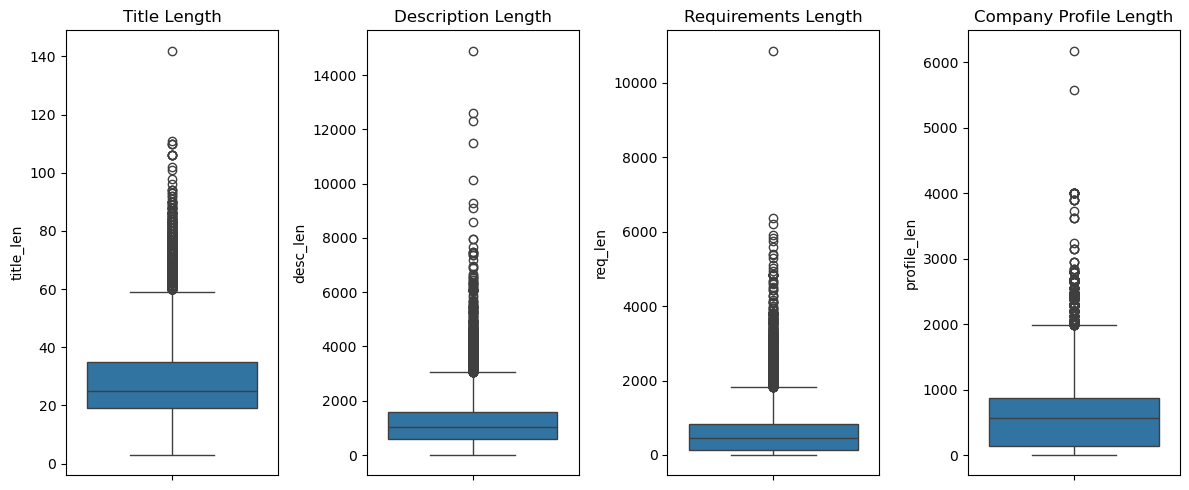

In [38]:
# visualizing outliers
# calculate 95th percentile
title_threshold = df['title_len'].quantile(0.95)
desc_threshold = df['desc_len'].quantile(0.95)
req_threshold = df['req_len'].quantile(0.95)
profile_threshold = df['profile_len'].quantile(0.95)

# id outliers for later use potentially
df['title_len_outlier'] = (df['title_len'] > title_threshold).astype(int)
df['desc_len_outlier'] = (df['desc_len'] > desc_threshold).astype(int)
df['req_len_outlier'] = (df['req_len'] > req_threshold).astype(int)
df['profile_len_outlier'] = (df['profile_len'] > profile_threshold).astype(int)

plt.figure(figsize=(12, 5))

plt.subplot(1, 4, 1)
sns.boxplot(y=df['title_len'])
plt.title('Title Length')

plt.subplot(1, 4, 2)
sns.boxplot(y=df['desc_len'])
plt.title('Description Length')

plt.subplot(1, 4, 3)
sns.boxplot(y=df['req_len'])
plt.title('Requirements Length')

plt.subplot(1, 4, 4)
sns.boxplot(y=df['profile_len'])
plt.title('Company Profile Length')

plt.tight_layout()
plt.show()

# Feature Selection & Modeling

In [39]:
# reset target column to int
df['fraudulent'] = df['fraudulent'].astype(int)

# for the initial DistilBERT, let's start with just the job description and target column
df_model = df[['description', 'fraudulent']].copy()

df_model.head()


,description,fraudulent
0,"Food52, a fast-growing, James Beard Award-winn...",0
1,Organised - Focused - Vibrant - Awesome!Do you...,0
2,"Our client, located in Houston, is actively se...",0
3,THE COMPANY: ESRI – Environmental Systems Rese...,0
4,JOB TITLE: Itemization Review ManagerLOCATION:...,0


In [40]:
# split data to train/val/test - we'll use 80/10/10
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_model['description'].tolist(),
    df_model['fraudulent'].tolist(),
    test_size=0.2,
    stratify=df_model['fraudulent'],
    random_state=100
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=100
)


In [41]:
# we're using DistilBERT, let's load in tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# tokenize datasets
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")


In [42]:
# create PyTorch Dataset
class JobDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# wrap each dataset
train_dataset = JobDataset(train_encodings, train_labels)
val_dataset = JobDataset(val_encodings, val_labels)
test_dataset = JobDataset(test_encodings, test_labels)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# check dataset sizes
print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 14304
Validation size: 1788
Test size: 1788


In [43]:
# use GPU if we can
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [44]:
# load in DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2 
)
model.to(device)

# set optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
# handle class imbalance with class weights
train_label_counts = np.bincount(train_labels)
class_weights = [1.0 / c for c in train_label_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# create trainer with weight loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # apply weighted loss
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [48]:
# load accuracy
accuracy_metric = load_metric("accuracy")

# create compute_metrics functions
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# define training parameters
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# train the model
trainer.train()

C:\Users\Donva\AppData\Local\Temp\ipykernel_19820\1636435234.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedLossTrainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.647800,0.484492,0.974273
2,0.332400,0.350115,0.968121
3,0.147100,0.470298,0.979306


TrainOutput(global_step=2682, training_loss=0.3757839956717381, metrics={'train_runtime': 1194.8228, 'train_samples_per_second': 35.915, 'train_steps_per_second': 2.245, 'total_flos': 5684441011126272.0, 'train_loss': 0.3757839956717381, 'epoch': 3.0})

In [49]:
# predict on test data
predictions = trainer.predict(test_dataset)

# store predictions
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# create classification report
report = classification_report(y_true, y_pred, target_names=["Real", "Fake"])
print(report)

              precision    recall  f1-score   support

        Real       0.99      0.99      0.99      1702
        Fake       0.77      0.84      0.80        86

    accuracy                           0.98      1788
   macro avg       0.88      0.91      0.90      1788
weighted avg       0.98      0.98      0.98      1788



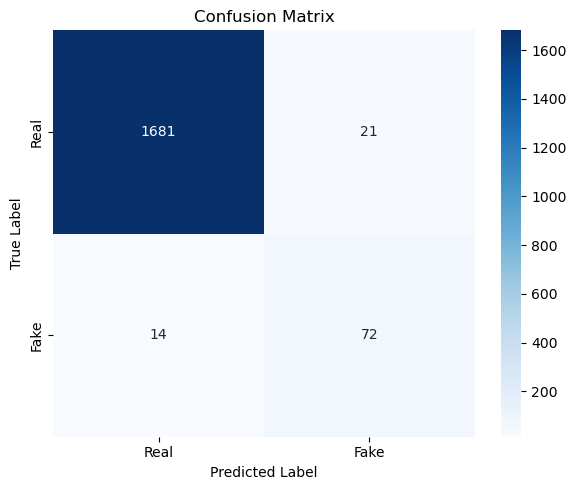

In [50]:
# define confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Matthew's Model Code

In [ ]:
# Stopwords list
stopwords = set([
    "a", "an", "the", "and", "or", "but", "if", "while", "with", "without",
    "in", "on", "at", "to", "from", "by", "for", "of", "as", "is", "are", "was",
    "were", "be", "been", "being", "this", "that", "these", "those", "it", "its",
    "he", "she", "they", "them", "his", "her", "their", "you", "your", "we", "us"
])

In [ ]:
# Clean text
def preprocess_text(text):
    text = text.lower()
    tokens = re.findall(r'\b[a-z]{2,}\b', text)
    return ' '.join([t for t in tokens if t not in stopwords])

In [ ]:
# Prepare input text
df['text'] = df[['description', 'requirements', 'company_profile']].fillna('').agg(' '.join, axis=1)
df['clean_text'] = df['text'].apply(preprocess_text)

In [ ]:
# Load Hugging Face model and tokenizer
print("Loading transformer model...")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")
model.eval()


In [ ]:
# Function to get mean pooled embedding
def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [ ]:
# Generate embeddings for each job posting
print("Generating embeddings...")
embeddings = np.vstack([get_embedding(text) for text in tqdm(df['clean_text'])])

In [ ]:
# TF-IDF feature extraction
print("Extracting TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf_vectorizer.fit_transform(df['clean_text'])

In [ ]:
# LDA topic modeling
print("Running LDA topic modeling...")
count_vectorizer = CountVectorizer(max_features=1000)
count_matrix = count_vectorizer.fit_transform(df['clean_text'])
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_topics = lda_model.fit_transform(count_matrix)

In [ ]:
# Combine features
print("Combining features...")
X_combined = hstack([tfidf_features, lda_topics, embeddings])
y = df['fraudulent']

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
# Train classifier
print("Training classifier...")
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

In [ ]:
# Predictions and report
y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Evaluation

# Deployment

# Discussion and Conclusions